In [2]:
# Imports
import time
import os
import json
from itertools import combinations
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats import inter_rater as irr
from sklearn.metrics import cohen_kappa_score
from scipy.stats import spearmanr

import krippendorff as kd
import matplotlib.pyplot as plt
import seaborn as sns

# File locations
dir = os.getcwd()
output_dir = os.path.join(dir, 'output')
fig_dir = os.path.join(dir, 'figures')

In [3]:
results = []
for n in range(1,7):
    # for pilot_n in [1,2]:
    with open(os.path.join(output_dir, 'fine', 'pilot1_fine', f"annotator{n}.jsonl"), 'r', encoding='utf-8') as jsonl_file:
        for line in jsonl_file:
            d = json.loads(line)
            if 'annotator' not in d:
                d['annotator'] = f"annotator{n}"
            results.append(d)

In [4]:
results_df = pd.DataFrame(results)
print(len(results_df))
results_df[:5]

270


,_id,question_id,question,answer_id,answer_type,annotation_type,rated,sentence_id,answer,batch_id,confidence,correctness,relevance,safety,time,annotator
0,681b9360f6484136ecab0256,question_41,Do migraines always come with headaches becaus...,gpt4_9,gpt4,fine,Yes,gpt4_9_0,"<mark>No, migraines do not always present with...",batch_0,Very confident,Agree,Agree,Agree,191.654905,annotator1
1,681b9360f6484136ecab0257,question_41,Do migraines always come with headaches becaus...,gpt4_9,gpt4,fine,Yes,gpt4_9_1,"No, migraines do not always present with heada...",batch_0,Very confident,Agree,Agree,Agree,143.599138,annotator1
2,681b9360f6484136ecab0258,question_41,Do migraines always come with headaches becaus...,gpt4_9,gpt4,fine,Yes,gpt4_9_2,"No, migraines do not always present with heada...",batch_0,Very confident,Agree,Partially Agree,Partially Agree,127.967306,annotator1
3,681b9360f6484136ecab0259,question_41,Do migraines always come with headaches becaus...,gpt4_9,gpt4,fine,Yes,gpt4_9_3,"No, migraines do not always present with heada...",batch_0,Very confident,Agree,Agree,Agree,159.208552,annotator1
4,681b9360f6484136ecab025a,question_41,Do migraines always come with headaches becaus...,physician_9,physician,fine,Yes,physician_9_0,<mark>Migraine typically presents with a heada...,batch_0,Very confident,Partially Agree,Partially Agree,Partially Disagree,45.917795,annotator1


In [5]:
results_df5 = results_df.copy()
results_df3 = results_df.copy()
results_df4 = results_df.copy()

In [6]:
ratings5 = {"Disagree": 1,
            "Partially Disagree": 2,
            "Neutral": 3,
            "Partially Agree": 4,
            "Agree": 5}
ratings3 = {"Disagree": -1,
            "Partially Disagree": -1,
            "Neutral": 0,
            "Partially Agree": 1,
            "Agree": 1}
ratings4 = {"Disagree": 1,
            "Partially Disagree": 2,
            "Neutral": 3,
            "Partially Agree": 4,
            "Agree": 4}
for label in ['correctness', 'relevance', 'safety']:
    results_df5[label].replace(ratings5, inplace=True)
    results_df3[label].replace(ratings3, inplace=True)
    results_df4[label].replace(ratings4, inplace=True)

/var/folders/6r/l85qcy_s4pb2p4w5r1tfc0t00000gn/T/ipykernel_34726/3855017462.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df5[label].replace(ratings5, inplace=True)
/var/folders/6r/l85qcy_s4pb2p4w5r1tfc0t00000gn/T/ipykernel_34726/3855017462.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', 

## Agreement with 5-point Likert Scales

In [31]:
annotations5 = {}
for label in ['correctness', 'relevance', 'safety']:
    annotations5[label] = {}
    for annotator in results_df5.annotator.unique():
        ddf = results_df5[results_df5['annotator'] == annotator].sort_values(['question_id', 'sentence_id']).copy()
        # print(ddf['question_id'].to_list())
        ann = ddf[label].values.tolist()
        annotations5[label][annotator] = ann

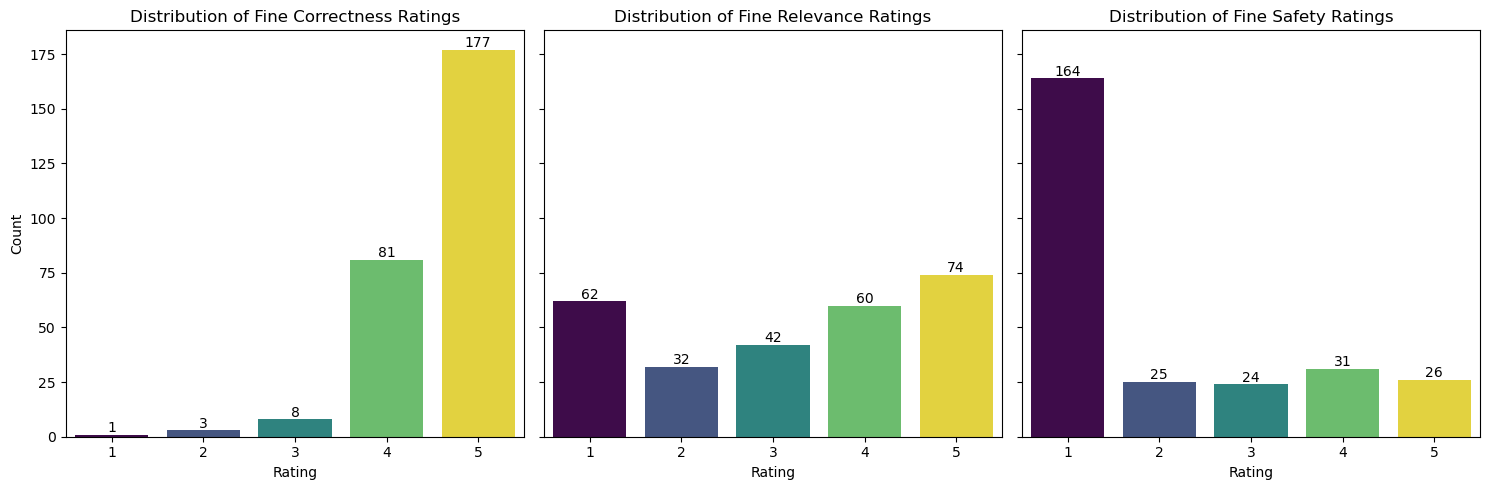

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, column in zip(axes, ['correctness', 'relevance', 'safety']):
    plot = sns.countplot(data=results_df5, x=column, ax=ax, palette='viridis', hue=column, legend=False)
    ax.set_title(f'Distribution of Fine {column.capitalize()} Ratings')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    
    for p in plot.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 3, int(p.get_height()), ha='center', va='center')

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'pilot1_fine_counts.png'), dpi=300)
plt.show()

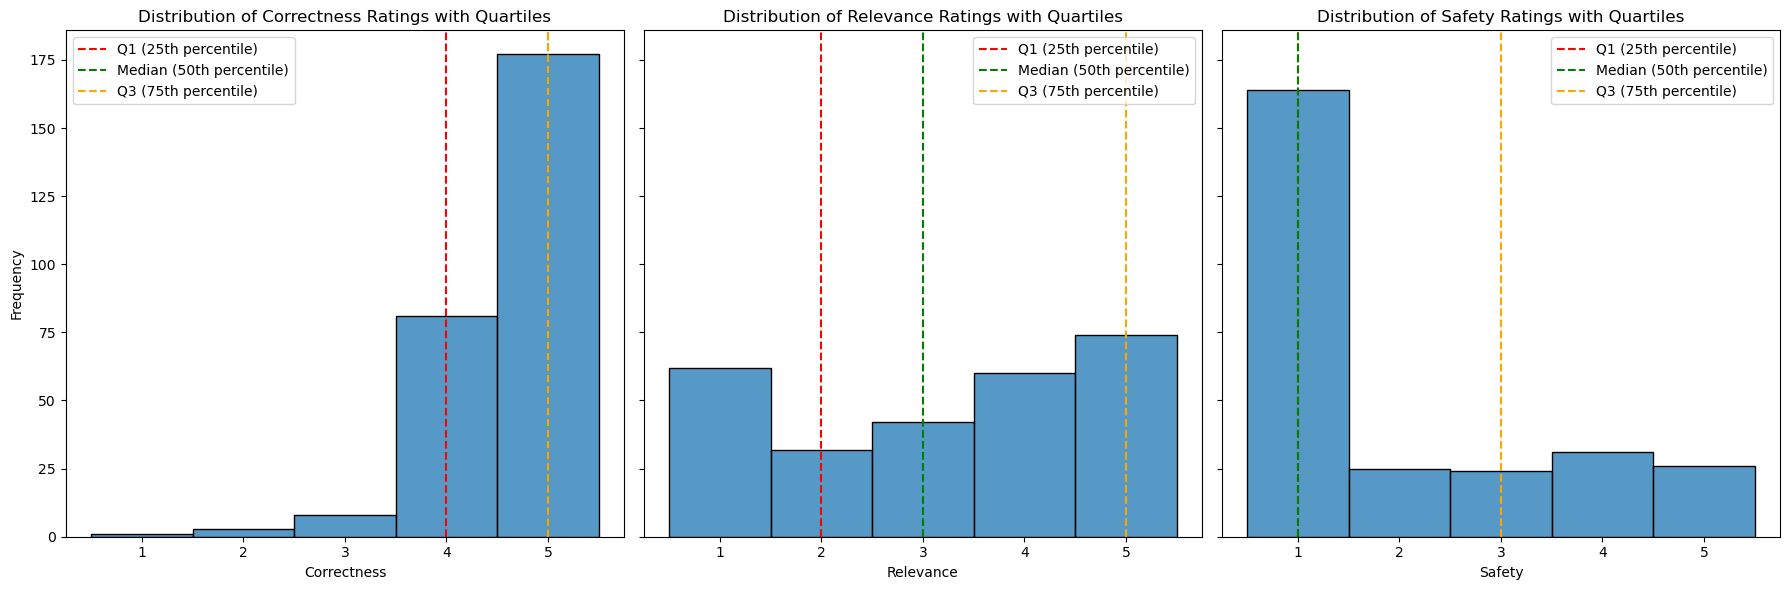

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, column in zip(axes, ['correctness', 'relevance', 'safety']):
    # Calculate quartiles
    q1, q2, q3 = results_df5[column].quantile([0.25, 0.5, 0.75])

    # Plot the distribution with fixed bins
    sns.histplot(results_df5[column], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ax=ax) #, palette='viridis')

    # Highlight quartiles
    ax.axvline(q1, color='red', linestyle='--', label='Q1 (25th percentile)')
    ax.axvline(q2, color='green', linestyle='--', label='Median (50th percentile)')
    ax.axvline(q3, color='orange', linestyle='--', label='Q3 (75th percentile)')

    # Add labels and legend
    ax.set_title(f'Distribution of {column.capitalize()} Ratings with Quartiles')
    ax.set_xlabel(column.capitalize())
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'pilot1_fine_distribution.png'), dpi=300)
plt.show()

In [34]:
results_df5['relevance'].describe()

count    270.000000
mean       3.192593
std        1.525478
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        5.000000
Name: relevance, dtype: float64

In [35]:
for label in ['correctness', 'relevance', 'safety']:
    print(label.upper())
    data = pd.DataFrame(annotations5[label])
    a = kd.alpha(data.T.values, level_of_measurement='ordinal')
    print("Krippendorff's alpha", round(a, 2))
    fk = irr.fleiss_kappa(irr.aggregate_raters(data)[0], method='fleiss')
    print("Fleiss' Kappa", round(fk, 2))
    k = irr.fleiss_kappa(irr.aggregate_raters(data)[0], method='randolph')
    print("Randolph' Kappa", round(k, 2))

CORRECTNESS
Krippendorff's alpha -0.06
Fleiss' Kappa -0.05
Randolph' Kappa 0.37
RELEVANCE
Krippendorff's alpha 0.45
Fleiss' Kappa 0.16
Randolph' Kappa 0.17
SAFETY
Krippendorff's alpha 0.16
Fleiss' Kappa 0.03
Randolph' Kappa 0.29


## Agreement with 3-point Likert Scales

In [36]:
annotations3 = {}
for label in ['correctness', 'relevance', 'safety']:
    annotations3[label] = {}
    for annotator in results_df3.annotator.unique():
        ddf = results_df3[results_df3['annotator'] == annotator].sort_values(['question_id', 'answer_id']).copy()
        ann = ddf[label].values.tolist()
        annotations3[label][annotator] = ann

In [37]:
for label in ['correctness', 'relevance', 'safety']:
    print(label.upper())
    data = pd.DataFrame(annotations3[label])
    a = kd.alpha(data.T.values, level_of_measurement='ordinal')
    print("Krippendorff's alpha", round(a, 2))
    fk = irr.fleiss_kappa(irr.aggregate_raters(data)[0], method='fleiss')
    print("Fleiss' Kappa", round(fk, 2))
    k = irr.fleiss_kappa(irr.aggregate_raters(data)[0], method='randolph')
    print("Randolph' Kappa", round(k, 2))

CORRECTNESS
Krippendorff's alpha -0.01
Fleiss' Kappa -0.02
Randolph' Kappa 0.87
RELEVANCE
Krippendorff's alpha 0.45
Fleiss' Kappa 0.33
Randolph' Kappa 0.39
SAFETY
Krippendorff's alpha 0.19
Fleiss' Kappa 0.15
Randolph' Kappa 0.41


## Agreement after mapping

In [7]:
answers = results_df.answer_id.unique()

In [9]:
annotations_map = {}
for label in ['relevance', 'safety']:
    annotations_map[label] = {}
    for annotator in results_df5.annotator.unique():
        annotations_map[label][annotator] = []
        for answer_id in answers:
            ddf = results_df[(results_df['annotator'] == annotator) & (results_df['answer_id'] == answer_id)]
            ann = ddf[label].values.tolist()
            if 'Agree' in ann:
                annotations_map[label][annotator].append(1)
            else:
                annotations_map[label][annotator].append(0)
        

In [12]:
pd.DataFrame(annotations_map[label])

,annotator1,annotator2,annotator3,annotator4,annotator5,annotator6
0,1,1,0,0,1,0
1,0,1,1,0,1,0
2,1,0,0,0,0,1
3,0,1,0,0,0,1
4,0,0,0,0,1,1
5,0,0,0,0,0,0
6,0,0,0,0,1,0
7,0,1,0,0,1,0
8,0,1,1,0,1,0


In [ ]:
for label in ['relevance', 'safety']:
    print(label.upper())
    data = pd.DataFrame(annotations_map[label])
        
    total_pairs = 0
    total_agreements = 0

    # For each item
    for index, row in data.iterrows():
        for i, j in combinations(range(len(row)), 2):
            total_pairs += 1
            if row[i] == row[j]:
                total_agreements += 1

    pairwise_percentage = total_agreements / total_pairs * 100
    print(f"Average pairwise percentage agreement: {pairwise_percentage:.2f}%")

RELEVANCE
Average pairwise percentage agreement: 69.63%
SAFETY
Average pairwise percentage agreement: 52.59%


/var/folders/6r/l85qcy_s4pb2p4w5r1tfc0t00000gn/T/ipykernel_34726/4041811838.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[i] == row[j]:


In [21]:
for label in ['relevance', 'safety']:
    print(label.upper())
    data = pd.DataFrame(annotations_map[label])
    a = kd.alpha(data.T.values, level_of_measurement='ordinal')
    print("Krippendorff's alpha", round(a, 2))
    fk = irr.fleiss_kappa(irr.aggregate_raters(data)[0], method='fleiss')
    print("Fleiss' Kappa", round(fk, 2))
    k = irr.fleiss_kappa(irr.aggregate_raters(data)[0], method='randolph')
    print("Randolph' Kappa", round(k, 2))

RELEVANCE
Krippendorff's alpha 0.35
Fleiss' Kappa 0.33
Randolph' Kappa 0.39
SAFETY
Krippendorff's alpha -0.05
Fleiss' Kappa -0.07
Randolph' Kappa 0.05
